In [1]:
import os, sys, glob
import numpy as np
from scipy import sparse
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
import lightkurve as lk
from astropy.io import fits
import astropy.units as u
from astropy.time import Time
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord, match_coordinates_3d
from astropy.stats import sigma_clip, SigmaClip
from astropy.wcs import WCS
from astropy.modeling import models, fitting
import warnings
from photutils import (Background2D, MedianBackground,
                       BkgIDWInterpolator, BkgZoomInterpolator)  # For interpolating background

%matplotlib inline
path = os.path.dirname(os.getcwd()) 

sys.path.append(path)
from exba.utils import get_gaia_sources, make_A, solve_linear_model

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Load image and header

Q 5 Ch [5, 6, 7, 8] dont have WCS in the header

In [2]:
quarter = 5
fits_list = np.sort(glob.glob("%s/data/ffi/5/kplr*_ffi-cal.fits" % (path)))
CH = 2
test_file = fits_list[1]
print(test_file)
hdr = fits.open(test_file)[CH].header
img = fits.open(test_file)[CH].data
wcs = WCS(hdr)

print(img.shape)
print(wcs)

/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/ffi/5/kplr2010140101631_ffi-cal.fits
(1070, 1132)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 283.1317320851647  43.33349115566128  
CRPIX : 533.0  521.0  
CD1_1 CD1_2  : -0.0006833209829737  -0.000867748944927  
CD2_1 CD2_2  : 0.0008679704840651109  -0.0006836300200241  
NAXIS : 1132  1070


## Get ra dec coordinates

In [3]:
row_2d, col_2d = np.mgrid[: img.shape[0], : img.shape[1]]
row, col = row_2d.ravel(), col_2d.ravel()
ra, dec = wcs.all_pix2world(np.vstack([col, row]).T, 0).T
ra_2d, dec_2d = ra.reshape(img.shape), dec.reshape(img.shape)

print(col_2d.shape, row_2d.shape, ra_2d.shape, col_2d.shape)

(1070, 1132) (1070, 1132) (1070, 1132) (1070, 1132)


## Find center coordinates for query

In [4]:
loc = (img.shape[0]//2, img.shape[1]//2)
ra_q, dec_q = wcs.all_pix2world(np.atleast_2d(loc), 0).T
rad = [np.hypot(ra - ra.mean(), dec - dec.mean()).max()]

time = Time(hdr['TSTART'] + 2454833, format="jd")
print(loc)
print(ra_q, dec_q, rad, time.jyear)

(535, 566)
[283.07406154] [43.30463298] [1.1783294449262118] 2010.3816829217799


In [5]:
csv_file = "channel_%i_gaia_xmatch.csv" % (CH)
print(csv_file)
#sources.to_csv('%s/data/ffi/%s' % (path, csv_file))
sources = pd.read_csv('%s/data/ffi/%i/%s' % (path, quarter, csv_file))

channel_2_gaia_xmatch.csv


In [6]:
sources['col'], sources['row'] = wcs.all_world2pix(
    sources.loc[:, ['ra','dec']].values, .5).T

In [7]:
r_min, r_max = 20, 1044
c_min, c_max = 12, 1112

In [8]:
def clean_source_list(sources, ra, dec):
    
    # remove bright/faint objects
    sources = sources[(sources.phot_g_mean_flux > 1e3) & 
                      (sources.phot_g_mean_flux < 1e6)].reset_index(drop=True)
    print(sources.shape)

    # find well separated sources
    s_coords = SkyCoord(sources.ra, sources.dec, unit=("deg"))
    midx, mdist = match_coordinates_3d(s_coords, s_coords, nthneighbor=2)[:2]
    # remove sources closer than 4" = 1 pix
    closest = mdist.arcsec < 8.0
    blocs = np.vstack([midx[closest], np.where(closest)[0]])
    bmags = np.vstack(
        [
            sources.phot_g_mean_mag[midx[closest]],
            sources.phot_g_mean_mag[np.where(closest)[0]],
        ]
    )
    faintest = [blocs[idx][s] for s, idx in enumerate(np.argmax(bmags, axis=0))]
    unresolved = np.in1d(np.arange(len(sources)), faintest)
    del s_coords, midx, mdist, closest, blocs, bmags

    sources = sources[~unresolved].reset_index(drop=True)
    print(sources.shape)

    # find sources on the image
    #inside = np.zeros(len(sources), dtype=bool)
    # max distance in arcsec from image edge to source ra, dec
    #off = 4.0 / 3600
    #for k in range(len(sources)):
    #    raok = (sources["ra"][k] > ra - off) & (sources["ra"][k] < ra + off)
    #    decok = (sources["dec"][k] > dec - off) & (sources["dec"][k] < dec + off)
    #    inside[k] = (raok & decok).any()
    #del raok, decok
    
    inside = ((sources.row > 10) & (sources.row < 1014) & 
              (sources.col > 10) & (sources.col < 1090))
    sources = sources[inside].reset_index(drop=True)
    print(sources.shape)

    return sources

## Cutout the useless pixels

In [9]:
_col_2d = col_2d[r_min : r_max, c_min : c_max] - c_min
_row_2d = row_2d[r_min : r_max, c_min : c_max] - r_min
_ra_2d = ra_2d[r_min : r_max, c_min : c_max]
_dec_2d = dec_2d[r_min : r_max, c_min : c_max]
_flux_2d = img[r_min : r_max, c_min : c_max]

_col = _col_2d.ravel()
_row = _row_2d.ravel()
_ra = _ra_2d.ravel()
_dec = _dec_2d.ravel()
_flux = _flux_2d.ravel()

print(_col_2d.shape, _row_2d.shape, _ra_2d.shape, 
      _dec_2d.shape, _flux_2d.shape)
print(_col.shape, _row.shape, _ra.shape, _dec.shape, _flux.shape)

(1024, 1100) (1024, 1100) (1024, 1100) (1024, 1100) (1024, 1100)
(1126400,) (1126400,) (1126400,) (1126400,) (1126400,)


In [10]:
_sources = sources.copy()
_sources.row -= r_min 
_sources.col -= c_min 
_sources = clean_source_list(_sources, _ra, _dec)

(28172, 21)
(26602, 21)
(8044, 21)


## Fit BKG

### BKG MASK

In [109]:
source_mask = [
                np.hypot(_col - s.col, _row - s.row) < 4.
                for _, s in _sources.iterrows()
            ]

In [112]:
source_mask = sparse.csr_matrix(source_mask)

In [169]:
source_mask

<11098x1126400 sparse matrix of type '<class 'numpy.bool_'>'
	with 558010 stored elements in Compressed Sparse Row format>

In [172]:
source_mask.sum(axis=0)

matrix([[0, 0, 0, ..., 0, 0, 0]])

In [173]:
mask = source_mask.sum(axis=0).reshape(_flux_2d.shape) > 0 
type(mask)

numpy.matrix

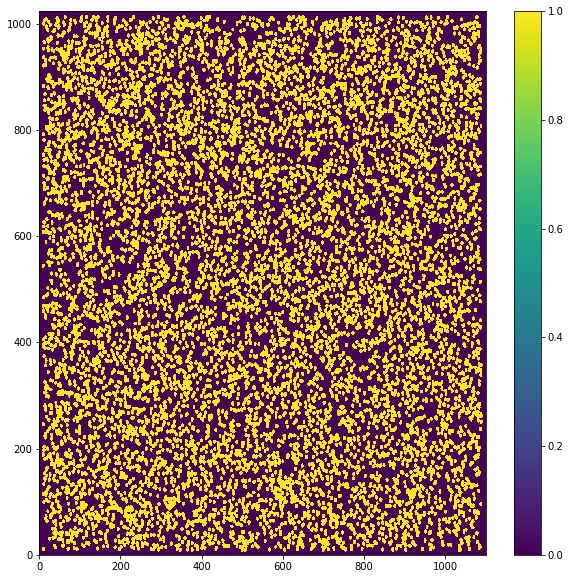

In [174]:
plt.figure(figsize=(10, 10))
cax = plt.pcolor(np.array(mask))
plt.colorbar(cax)
plt.show()

In [194]:
def background2d(data, mask=None):
    '''
    BkgZoomInterpolator:
    This class generates full-sized background and background RMS images
from lower-resolution mesh images using the `~scipy.ndimage.zoom`
(spline) interpolator.
    '''
    clipping = SigmaClip(sigma=3., maxiters=5)
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, box_size=50, filter_size=5, exclude_percentile=80,
                       mask=mask,
                       sigma_clip=clipping,
                       bkg_estimator=bkg_estimator, 
                       interpolator=BkgZoomInterpolator(order=2))
    return bkg

In [195]:
bkg_model_mask = background2d(_flux_2d, mask=~mask)
bkg_model = background2d(_flux_2d, mask=None)

In [198]:
bkg_model_mask.background_median, bkg_model.background_median

(177.44522094726562, 171.34772)

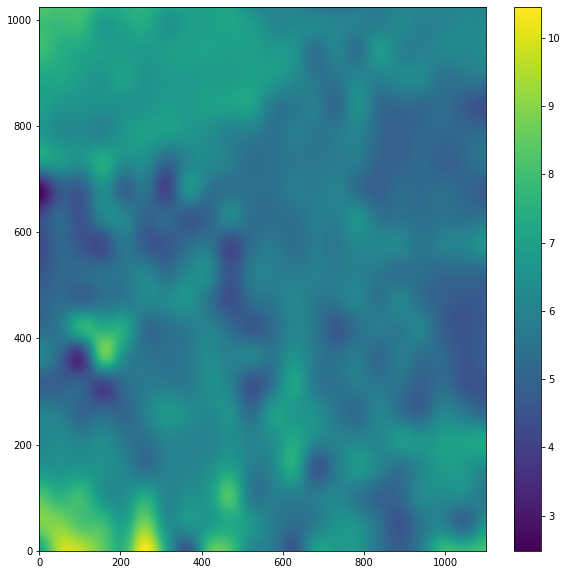

In [196]:
plt.figure(figsize=(10, 10))
cax = plt.pcolor(bkg_model_mask.background - bkg_model.background)
plt.colorbar(cax)
plt.show()

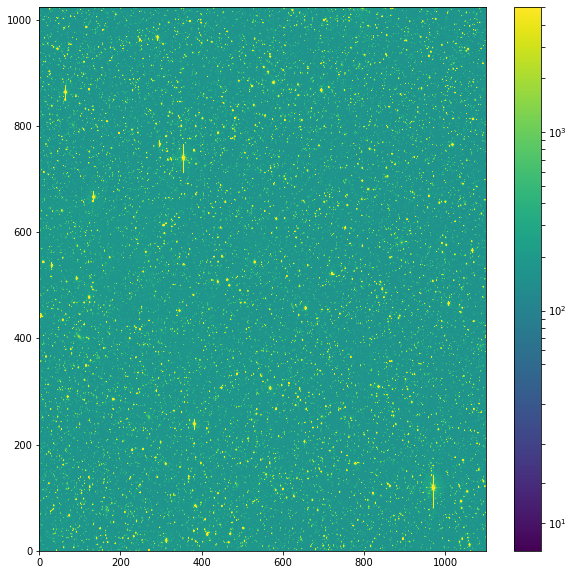

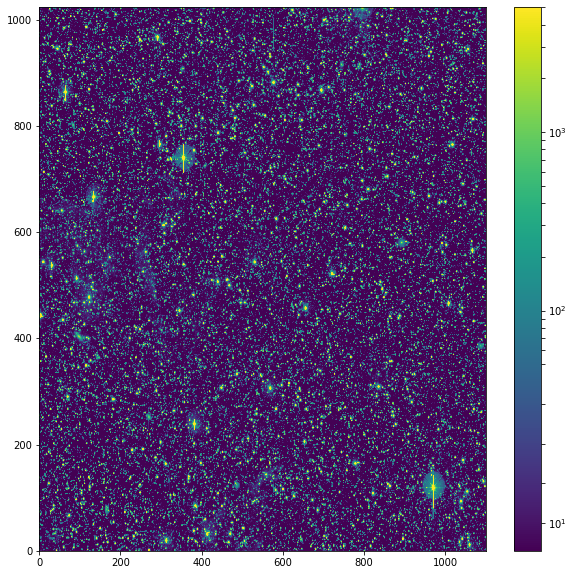

In [105]:
plt.figure(figsize=(10, 10))
cax = plt.pcolor(_flux_2d, norm=colors.SymLogNorm(linthresh=50, vmin=3, vmax=5000, base=10))
plt.colorbar(cax)
plt.show()

plt.figure(figsize=(10, 10))
cax = plt.pcolor(_flux_2d - bkg_model.background, norm=colors.SymLogNorm(linthresh=50, vmin=3, vmax=5000, base=10))
plt.colorbar(cax)
plt.show()

In [199]:
_flux_2d_bkg = _flux_2d - bkg_model_mask.background

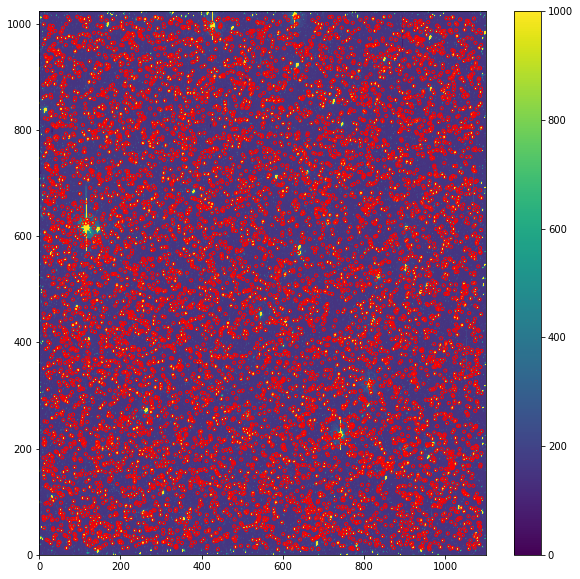

In [14]:
plt.figure(figsize=(10, 10))
cax = plt.pcolor(_flux_2d, vmin=0, vmax=1000)
plt.colorbar(cax)
plt.scatter(_sources.col, _sources.row, 
            edgecolor='red', facecolor='None', s=10)
plt.show()

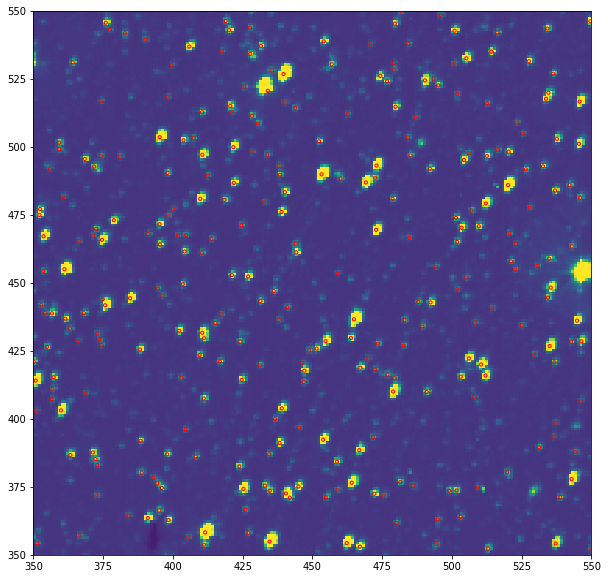

In [11]:
plt.figure(figsize=(10, 10))
cax = plt.pcolor(_flux_2d, vmin=0, vmax=1000)
plt.scatter(_sources.col, _sources.row, 
            edgecolor='red', facecolor='None', s=10)
plt.xlim(350, 550)
plt.ylim(350, 550)
plt.show()

## Remove background and saturated pixels

In [12]:
def _saturated_pixels_mask(flux, column, row, saturation_limit=1.5e5):
    """Finds and removes saturated pixels, including bleed columns."""
    # Which pixels are saturated
    #saturated = np.nanpercentile(flux, 99.99, axis=0)
    saturated = np.where((flux > saturation_limit).astype(float))[0]

    # Find bad pixels, including allowence for a bleed column.
    bad_pixels = np.vstack([np.hstack([column[saturated] + idx for idx in np.arange(-3, 3)]), 
                            np.hstack([row[saturated] for idx in np.arange(-3, 3)])]).T
    # Find unique row/column combinations
    bad_pixels = bad_pixels[np.unique([''.join(s) for s in bad_pixels.astype(str)], return_index=True)[1]]
    # Build a mask of saturated pixels
    m = np.zeros(len(column), bool)
    for p in bad_pixels:
        m |= (column == p[0]) & (row == p[1])
    return m

In [13]:
non_sat_mask = ~_saturated_pixels_mask(_flux, _col, _row, saturation_limit=1.5e5)
non_sat_mask.sum(), _flux.shape, non_sat_mask.shape

(1122478, (1126400,), (1126400,))

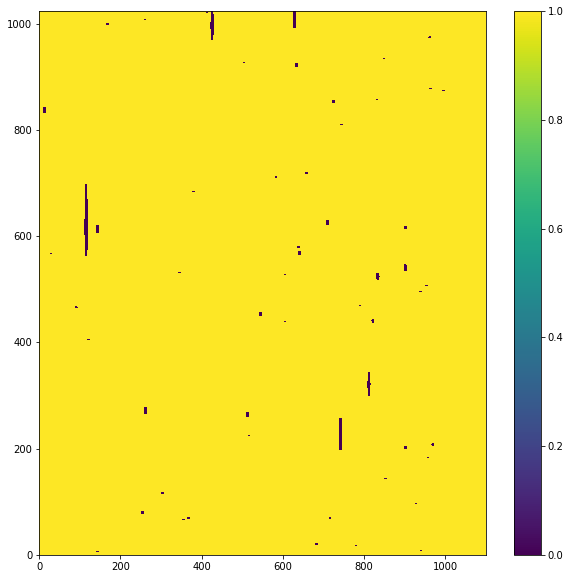

In [14]:
plt.figure(figsize=(10, 10))
cax = plt.pcolor(non_sat_mask.reshape(_flux_2d.shape))
plt.colorbar(cax)
plt.show()

#### remove saturated and background pixels

## Prepare data for PSF estimation

In [17]:
def custom_sample_sources(sources):
    bright = sources.query('phot_g_mean_flux > 1e5')
    print(bright.shape)
    medium = sources.query('phot_g_mean_flux > 1e4 and phot_g_mean_flux <= 1e5').sample(300)
    print(medium.shape)
    faint = sources.query('phot_g_mean_flux <= 1e4').sample(300)
    
    return pd.concat([bright, medium, faint], axis=0)

In [15]:
_sources = _sources.sample(100)
#_sources = sample_sources(_sources)
_sources.shape

(100, 21)

In [16]:
_sources

,Unnamed: 0,designation,source_id,ra,ra_error,dec,dec_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,...,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,bp_rp,ra_gaia,dec_gaia,col,row
4752,22376,Gaia DR2 2105071468727620992,2105071468727620992,283.834071,0.658731,43.522639,0.654220,2104.376192,7.220583,17.380558,...,8.787643,17.824852,1751.517063,7.302660,16.653383,1.171469,283.834071,43.522639,370.646420,30.475594
2981,19297,Gaia DR2 2104996289619783296,2104996289619783296,283.245636,0.017708,43.053806,0.020433,32617.625588,8.557218,14.404735,...,31.718791,14.671647,20583.112095,32.200929,13.978143,0.693504,283.245637,43.053801,274.506079,597.379387
3839,20744,Gaia DR2 2105064631139185024,2105064631139185024,284.020702,0.041109,43.289361,0.044858,4579.043076,3.214624,16.536428,...,12.444102,17.032225,3558.427792,10.741171,15.883775,1.148450,284.020699,43.289362,128.344364,62.300653
3564,20304,Gaia DR2 2104991582335698944,2104991582335698944,283.502817,0.037161,43.105201,0.047613,5910.379791,3.896742,16.259327,...,17.763266,16.510790,3655.110403,14.571658,15.854669,0.656121,283.502808,43.105185,206.241099,434.766981
3489,20179,Gaia DR2 2104996839375779456,2104996839375779456,283.153382,0.079045,43.051483,0.084633,2020.106147,1.979432,17.424930,...,14.561816,17.764456,1435.345164,15.906264,16.869530,0.894926,283.153378,43.051489,310.592587,646.655918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,3103,Gaia DR2 2105310440706680576,2105310440706680576,282.739092,0.072984,43.708755,0.084724,1793.859551,2.167309,17.553894,...,6.352306,18.009861,1344.283371,7.524849,16.940693,1.069168,282.739094,43.708751,946.218698,491.350566
6534,25580,Gaia DR2 2105140841039145344,2105140841039145344,283.289280,0.059462,43.878621,0.067110,2718.162360,2.513764,17.102676,...,11.138568,17.593801,2119.463201,9.373975,16.446356,1.147446,283.289276,43.878648,844.083038,113.867224
6771,26066,Gaia DR2 2105258660581982592,2105258660581982592,282.238031,0.074501,43.546328,0.096015,1581.713156,1.919339,17.690546,...,10.806840,18.098854,1142.438648,13.504810,17.117338,0.981516,282.238032,43.546320,1036.438213,839.428503
4647,22190,Gaia DR2 2105092973624969728,2105092973624969728,283.737769,0.039306,43.433953,0.043965,5317.243650,8.663293,16.374150,...,21.648165,16.813484,4036.124198,37.653852,15.747008,1.066476,283.737764,43.433942,345.961431,129.707873


In [17]:
# gaia estimate flux values per pixel to be used as flux priors
dx, dy, gf = np.asarray(
        [
            np.vstack(
                [
                    _col - _sources["col"].iloc[idx],
                    _row - _sources["row"].iloc[idx],
                    np.zeros(len(_col)) + _sources.phot_g_mean_flux.iloc[idx],
                ]
            )
            for idx in range(len(_sources))
        ]
    ).transpose([1, 0, 2])
print(dx.shape)

# convertion to polar coordinates
r = np.hypot(dx, dy)
phi = np.arctan2(dy, dx)
print(r.shape)

(100, 1126400)
(100, 1126400)


In [18]:
dx.shape, dy.shape, gf.shape, r.shape, phi.shape

((100, 1126400),
 (100, 1126400),
 (100, 1126400),
 (100, 1126400),
 (100, 1126400))

In [22]:
%%time
dx2, dy2, gf2, rtest, phitest = [], [], [], [], []
for i in range(len(_sources)):
    dx_aux = _col - _sources["col"].iloc[i]
    dy_aux = _row - _sources["row"].iloc[i]
    near_mask = sparse.csr_matrix((np.abs(dx_aux) <= 8) & (np.abs(dy_aux) <= 8))

    dx2.append(near_mask.multiply(dx_aux))
    dy2.append(near_mask.multiply(dy_aux))
    gf2.append(near_mask.multiply(_sources["phot_g_mean_flux"].iloc[i]))
    dx_ma = np.ma.masked_array(dx_aux, mask=~near_mask.toarray())
    dy_ma = np.ma.masked_array(dy_aux, mask=~near_mask.toarray())
    rtest.append(near_mask.multiply(np.hypot(dx_ma, dy_ma)))
    phitest.append(near_mask.multiply(np.arctan2(dy_ma, dx_ma)))

dx2 = sparse.vstack(dx2, 'csr')
dy2 = sparse.vstack(dy2, 'csr')
gf2 = sparse.vstack(gf2, 'csr')
rtest = sparse.vstack(rtest, 'csr')
phitest = sparse.vstack(phitest, 'csr')

CPU times: user 3.48 s, sys: 380 ms, total: 3.86 s
Wall time: 3.9 s


In [23]:
dx2, dy2, gf2, rtest, phitest

(<100x1126400 sparse matrix of type '<class 'numpy.float64'>'
 	with 25600 stored elements in Compressed Sparse Row format>,
 <100x1126400 sparse matrix of type '<class 'numpy.float64'>'
 	with 25600 stored elements in Compressed Sparse Row format>,
 <100x1126400 sparse matrix of type '<class 'numpy.float64'>'
 	with 25600 stored elements in Compressed Sparse Row format>,
 <100x1126400 sparse matrix of type '<class 'numpy.float64'>'
 	with 25600 stored elements in Compressed Sparse Row format>,
 <100x1126400 sparse matrix of type '<class 'numpy.float64'>'
 	with 25600 stored elements in Compressed Sparse Row format>)

In [64]:
%%time
dx3, dy3, stamp_mask = [], [], []
for i in range(len(_sources)):
    dx_aux = _col - _sources["col"].iloc[i]
    dy_aux = _row - _sources["row"].iloc[i]
    near_mask = sparse.csr_matrix((np.abs(dx_aux) <= 8) & (np.abs(dy_aux) <= 8))
    stamp_mask.append(near_mask)

    dx3.append(near_mask.multiply(dx_aux))
    dy3.append(near_mask.multiply(dy_aux))
    

dx3 = sparse.vstack(dx3, 'csr')
dy3 = sparse.vstack(dy3, 'csr')
stamp_mask = sparse.vstack(stamp_mask, 'csr')

CPU times: user 1.01 s, sys: 33.5 ms, total: 1.05 s
Wall time: 1.06 s


In [25]:
dx3, dy3, stamp_mask

(<100x1126400 sparse matrix of type '<class 'numpy.float64'>'
 	with 25600 stored elements in Compressed Sparse Row format>,
 <100x1126400 sparse matrix of type '<class 'numpy.float64'>'
 	with 25600 stored elements in Compressed Sparse Row format>,
 <100x1126400 sparse matrix of type '<class 'numpy.bool_'>'
 	with 25600 stored elements in Compressed Sparse Row format>)

In [71]:
r3 = stamp_mask.copy().astype(float)
phi3 = stamp_mask.copy().astype(float)

for row in range(stamp_mask.shape[0]):
    r3[row].data = np.hypot(dx3[row].data, dy3[row].data)
    phi3[row].data = np.arctan2(dy3[row].data, dx3[row].data)

In [72]:
r3, phi3

(<100x1126400 sparse matrix of type '<class 'numpy.float64'>'
 	with 25600 stored elements in Compressed Sparse Row format>,
 <100x1126400 sparse matrix of type '<class 'numpy.float64'>'
 	with 25600 stored elements in Compressed Sparse Row format>)

In [65]:
dflux3 = stamp_mask.multiply(_flux).tocsr()

In [96]:
stamp_mask

<100x1126400 sparse matrix of type '<class 'numpy.bool_'>'
	with 25600 stored elements in Compressed Sparse Row format>

In [103]:
nnz_inds = stamp_mask.nonzero()
r3_vals = np.hypot(dx3.data, dy3.data)
phi3_vals = np.arctan2(dy3.data, dx3.data)
stamp_mask.shape, nnz_inds[0].shape, nnz_inds[1].shape, r3_vals.shape

((100, 1126400), (25600,), (25600,), (25600,))

In [104]:
r3 = sparse.csr_matrix((r3_vals, (nnz_inds[0], nnz_inds[1])), shape=stamp_mask.shape, dtype=float)
phi3 = sparse.csr_matrix((phi3_vals, (nnz_inds[0], nnz_inds[1])), shape=stamp_mask.shape, dtype=float)

In [106]:
r3

<100x1126400 sparse matrix of type '<class 'numpy.float64'>'
	with 25600 stored elements in Compressed Sparse Row format>

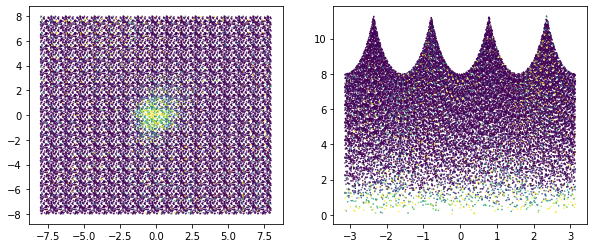

In [114]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

nan_mask = np.isfinite(dflux3.data)

ax[0].scatter(
    dx3.data[nan_mask],
    dy3.data[nan_mask],
    c=dflux3.data[nan_mask],
    marker=".",
    s=1,
    norm=colors.LogNorm(vmin=180, vmax=1000),
)

ax[1].scatter(
    phi3.data[nan_mask],
    r3.data[nan_mask],
    c=dflux3.data[nan_mask],
    marker=".",
    s=1,
    norm=colors.LogNorm(vmin=180, vmax=1000),
)

plt.show()

In [120]:
gf3 = stamp_mask.multiply(_sources["phot_g_mean_flux"].values[:, None]).tocsr()

In [126]:
gf3.eliminate_zeros()

In [133]:
gf_small = _sources["phot_g_mean_flux"].values

In [137]:
stamp_mask.multiply(gf_small[:, None])

<100x1126400 sparse matrix of type '<class 'numpy.float64'>'
	with 25600 stored elements in COOrdinate format>

In [136]:
stamp_mask.shape

(100, 1126400)

In [214]:
%%time
nonz_idx = r3.nonzero()
rad_mask = r3.data < 6.
custom = sparse.csr_matrix((r3.data[rad_mask], (nonz_idx[0][rad_mask], nonz_idx[1][rad_mask])), shape=r3.shape).astype(bool)

CPU times: user 2.24 ms, sys: 1.5 ms, total: 3.74 ms
Wall time: 2.65 ms


In [185]:
temp_mask = sparse.csr_matrix(r3 < 6.).multiply(r3.astype(bool))

In [212]:
(temp_mask == custom).data.all()

True

In [217]:
rad_limits = np.random.normal(2, .2, size=r3.shape[0])
rad_limits

array([2.05992473, 1.82915484, 1.8361955 , 2.00325721, 2.26915714,
       2.15391834, 2.22152022, 1.72556829, 2.23377623, 1.88901692,
       2.16062649, 2.1788853 , 1.84784588, 1.97590662, 1.80630185,
       1.74605049, 2.19372835, 2.28421644, 1.96091232, 1.52816728,
       2.08368534, 1.77487543, 2.17973321, 1.83355778, 2.00476901,
       1.79682768, 1.83544714, 1.99760955, 2.26166754, 1.92248006,
       1.71821516, 2.20987788, 1.98474399, 2.21043565, 2.09051212,
       2.17663574, 2.12535922, 1.91096046, 1.87978995, 1.88686415,
       1.85508768, 2.25039876, 2.07159171, 2.09427337, 2.26908485,
       1.57716632, 1.870972  , 2.02161584, 2.08915195, 1.81608207,
       1.6992139 , 1.64185624, 1.72978485, 1.88367111, 1.92770687,
       1.90788371, 1.81335373, 1.82293952, 1.82764333, 1.87517959,
       2.00583493, 1.97103588, 1.87039024, 2.03420467, 2.00613014,
       1.81329912, 2.07894876, 1.77774692, 2.28669951, 1.98818748,
       1.91808725, 1.78696445, 2.14949956, 2.03708656, 2.02238

In [218]:
new_mask = []
for s in range(r3.shape[0]):
    nonz_idx = r3[s].nonzero()
    rad_mask = r3[s].data < rad_limits[s]
    aux = sparse.csr_matrix((r3[s].data[rad_mask], 
                             (nonz_idx[0][rad_mask], nonz_idx[1][rad_mask])), 
                              shape=r3[s].shape).astype(bool)
    new_mask.append(aux)
new_mask = sparse.vstack(new_mask, "csr")

In [220]:
new_mask.multiply(r3).data

array([1.61097368, 1.51736518, 2.00238808, ..., 1.54599698, 1.33329156,
       1.77910823])

In [226]:
(new_mask.sum(axis=0) == 0).shape

(1, 1126400)

In [268]:
M = sparse.csr_matrix(np.array([[1,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,1,1], [0,0,0,0]]))
M.toarray(), M.data.shape

(array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 1],
        [0, 0, 0, 0]]),
 (4,))

In [269]:
M.data

array([1, 1, 1, 1])

In [270]:
newM = M.multiply(M.sum(axis=0) == 1).tocsr()
print(newM.data.shape)
newM.eliminate_zeros()
print(newM.data.shape)
newM.toarray()


(4,)
(4,)


array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 1],
       [0, 0, 0, 0]])

In [271]:
newM.data

array([1, 1, 1, 1])

3

In [173]:
radius_limit = radius_limit = 6.
mean_flux = _flux.copy()
temp_mask = (r < radius_limit)
temp_mask &= temp_mask.sum(axis=0) == 1
with np.errstate(divide="ignore", invalid="ignore"):
    f = np.log10((temp_mask.astype(float) * mean_flux))
f.shape

(100, 1126400)

In [110]:
aux_mask = sparse.csr_matrix(rtest >= radius_limit)

In [114]:
rtest.toarray().astype(bool)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [118]:
my_mask = sparse.csr_matrix(~sparse.csr_matrix(rtest >= radius_limit).toarray() & rtest.toarray().astype(bool))

In [ ]:
f

In [174]:
def find_psf_edge(radius_limit=6, cut=300, plot=True):
    k = np.isfinite(f[temp_mask])

    if plot:
        print(f[temp_mask][k].shape)
        plt.hist(f[temp_mask][k], bins=1000, color='k')

    A = np.vstack(
        [
            r[temp_mask] ** 0,
            #r[temp_mask],
            #1/r[temp_mask],
            np.exp(-r[temp_mask]),
            #r[temp_mask] ** 2,
            #r[temp_mask] ** 3,
            np.log10(gf[temp_mask]),
            #np.log10(gf[temp_mask]) ** 2,
        ]
    ).T
    for count in [0, 1]:
        sigma_w_inv = A[k].T.dot(A[k])
        B = A[k].T.dot(f[temp_mask][k])
        w = np.linalg.solve(sigma_w_inv, B)
        res = np.ma.masked_array(f[temp_mask], ~k) - A.dot(w)
        k &= ~sigma_clip(res, sigma=5).mask
    
    if plot:
        print(f[temp_mask][k].shape)
        plt.hist(f[temp_mask][k], bins=1000, color='g', label='clipped')
        plt.legend(loc='upper right')
        plt.xlabel('log(f)')
        plt.yscale('log')
        plt.show()

    if False:
        to_save = dict(A=A, B=B, w=w, k=k)
        output = "%s/data/ffi/psf_edge_model_ch%i.pkl" % (
            main_path, CH,
        )
        with open(output, "wb") as file:
            cPickle.dump(to_save, file)

    test_f = np.linspace(
        np.log10(gf.min()),
        np.log10(gf.max()),
        100,
    )
    test_r = np.arange(0, radius_limit, 0.25)
    test_r2, test_f2 = np.meshgrid(test_r, test_f)
    print('w', w.shape)

    test_val = (
        np.vstack(
            [
                test_r2.ravel() ** 0,
                #test_r2.ravel(),
                #1/test_r2.ravel(),
                np.exp(-test_r2.ravel()),
                #test_r2.ravel() ** 2,
                #test_r2.ravel() ** 3,
                test_f2.ravel(),
                #test_f2.ravel() ** 2,
            ]
        )
        .T.dot(w)
        .reshape(test_r2.shape)
    )
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(14, 5), facecolor="white")

        ax[0].scatter(r[temp_mask], f[temp_mask], s=0.4, c="k", 
                      alpha=.5, label="Data")
        ax[0].scatter(r[temp_mask][k], f[temp_mask][k], s=0.4, c="g", 
                      alpha=.5, label="Data clipped")
        ax[0].scatter(r[temp_mask][k], A[k].dot(w), c="r", s=0.4, 
                      alpha=.7, label="Model")
        ax[0].set(xlabel=("Radius [pix]"), ylabel=("log$_{10}$ Flux"))
        ax[0].legend(frameon=True)

        im = ax[1].pcolormesh(
            test_f2,
            test_r2,
            10 ** test_val,
            vmin=0,
            vmax=500,
            cmap="viridis",
            shading="auto",
        )
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("Contained PSF Flux [counts]")

        ax[1].set(
            ylabel=("Radius from Source [pix]"),
            xlabel=("log$_{10}$ Source Flux"),
        )
        plt.show()

    # find radius where flux > cut
    l = np.zeros(len(test_f)) * np.nan
    for idx in range(len(test_f)):
        loc = np.where(10 ** test_val[idx] < cut)[0]
        if len(loc) > 0:
            l[idx] = test_r[loc[0]]

    ok = np.isfinite(l)
    print(ok)
    source_radius_limit = np.polyval(
        np.polyfit(test_f[ok], l[ok], 2), np.log10(gf[:, 0])
    )
    source_radius_limit[source_radius_limit > radius_limit] = radius_limit
    source_radius_limit[source_radius_limit < 0] = 0
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(14, 5), facecolor="white")

        ax[0].scatter(r[temp_mask], f[temp_mask], s=0.4, c="k", 
                      alpha=.5, label="Data")
        ax[0].scatter(r[temp_mask][k], f[temp_mask][k], s=0.4, c="g", 
                      alpha=.5, label="Data clipped")
        ax[0].scatter(r[temp_mask][k], A[k].dot(w), c="r", s=0.4, 
                      alpha=.7, label="Model")
        ax[0].set(xlabel=("Radius [pix]"), ylabel=("log$_{10}$ Flux"))
        ax[0].legend(frameon=True)

        im = ax[1].pcolormesh(
            test_f2,
            test_r2,
            10 ** test_val,
            vmin=0,
            vmax=500,
            cmap="viridis",
            shading="auto",
        )
        line = np.polyval(np.polyfit(test_f[ok], l[ok], 2), test_f)
        line[line > radius_limit] = radius_limit
        ax[1].plot(test_f, line, color="r", label="Mask threshold")
        ax[1].legend(frameon=True)
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("Contained PSF Flux [counts]")

        ax[1].set(
            ylabel=("Radius from Source [pix]"),
            xlabel=("log$_{10}$ Source Flux"),
        )
        plt.show()

    
    return source_radius_limit

(11295,)
(10925,)


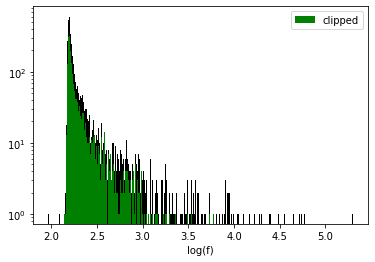

w (3,)


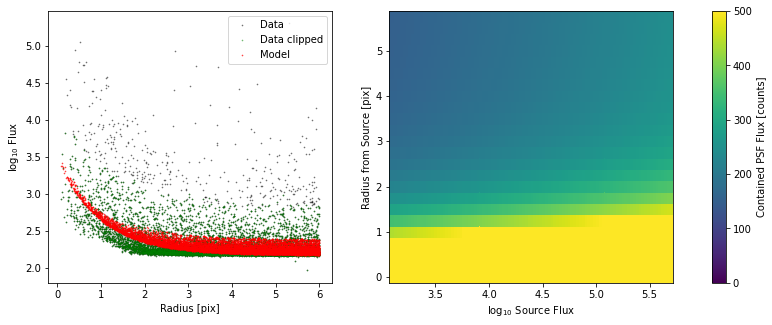

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


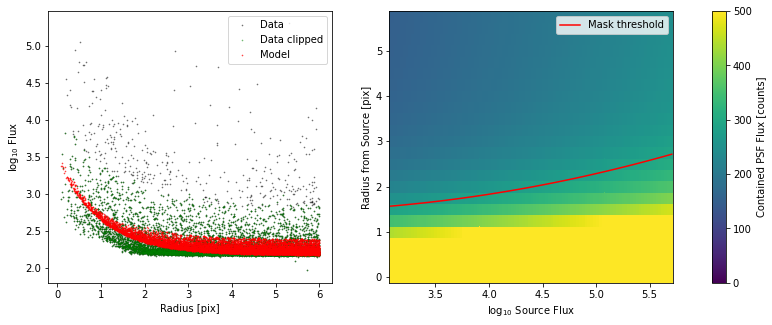

In [175]:
radius = find_psf_edge(radius_limit=radius_limit, cut=300)

In [223]:
radius = np.ones(len(_sources)) * 2.

In [176]:
rtest, radius.shape

(<100x1126400 sparse matrix of type '<class 'numpy.float64'>'
 	with 25600 stored elements in Compressed Sparse Row format>,
 (100,))

In [276]:
source_mask_v2 = sparse.csr_matrix(
        ~sparse.csr_matrix(rtest >= radius[:, None]).toarray() & rtest.toarray().astype(bool)
    )
source_mask_v2

<8044x1126400 sparse matrix of type '<class 'numpy.bool_'>'
	with 101164 stored elements in Compressed Sparse Row format>

In [252]:
source_mask_v2 = source_mask_v2.multiply(source_mask_v2.sum(axis=0) == 1)
source_mask_v2

<8044x1126400 sparse matrix of type '<class 'numpy.bool_'>'
	with 101164 stored elements in COOrdinate format>

In [277]:
mask_f = source_mask_v2.astype(float).multiply(_flux)
mask_gf = source_mask_v2.astype(float).multiply(gf2)

In [275]:
mask_f

<8044x1126400 sparse matrix of type '<class 'numpy.float64'>'
	with 101164 stored elements in COOrdinate format>

In [268]:
source_mask_v2.nonzero()

(array([3405, 3405, 3405, ..., 5600, 5800, 5800], dtype=int32),
 array([  10339,   10340,   10341, ..., 1117365, 1117465, 1117466],
       dtype=int32))

In [278]:
nonzeror, nonzeroc = source_mask_v2.nonzero()

In [266]:
masknonzero

array([3405, 3405, 3405, ..., 5600, 5800, 5800], dtype=int32)

In [279]:
gf2[nonzeror, nonzeroc].shape

(1, 101164)

In [280]:
_flux[nonzeror, nonzeroc].shape

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

4.440892098500626e-16

In [223]:
def build_psf_model(plot=True):
    #warnings.filterwarnings("ignore", category=sparse.SparseEfficiencyWarning)

    # assign the flux estimations to be used for mean flux normalization
    flux_estimates = gf
    source_mask = sparse.csr_matrix(r < 2 * radius[:, None])
    
    print(source_mask.shape)
    print(source_mask.astype(float).multiply(mean_flux).shape)

    # mean flux values using uncontaminated mask and normalized by flux estimations
    mean_f = np.log10(
        source_mask.astype(float)
        .multiply(mean_flux)
        .multiply(1 / flux_estimates)
        .data
    )
    phi_b = source_mask.multiply(phi).data
    r_b = source_mask.multiply(r).data

    # build a design matrix A with b-splines basis in radius and angle axis.
    A = make_A(phi_b.ravel(), r_b.ravel())
    prior_sigma = np.ones(A.shape[1]) * 100
    prior_mu = np.zeros(A.shape[1])
    nan_mask = np.isfinite(mean_f.ravel())

    # we solve for A * psf_w = mean_f
    psf_w = solve_linear_model(
        A,
        mean_f.ravel(),
        k=nan_mask,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
    )

    # We then build the same design matrix for all pixels with flux
    Ap = make_A(
        source_mask.multiply(phi).data,
        source_mask.multiply(r).data,
    )
    print('A      ', A.shape)
    print('mean_f ', mean_f.ravel().shape)
    print('psf_w  ', psf_w.shape)
    print('Ap     ', Ap.shape)

    # And create a `mean_model` that has the psf model for all pixels with fluxes
    mean_model = sparse.csr_matrix(r.shape)
    m = 10 ** Ap.dot(psf_w)
    mean_model[source_mask] = m
    mean_model.eliminate_zeros()
    mean_model = mean_model.multiply(1 / mean_model.sum(axis=1))

    if plot:
        # Plotting r,phi,meanflux used to build PSF model
        ylim = r_b.max() * 1.1
        vmin, vmax = mean_f.min(), mean_f.max()
        fig, ax = plt.subplots(1, 3, figsize=(15, 3))
        ax[0].set_title("Mean flux")
        cax = ax[0].scatter(
            source_mask.multiply(phi).data,
            source_mask.multiply(r).data,
            c=mean_f,
            marker=".",
            vmin=vmin,
            vmax=vmax
        )
        ax[0].set_ylim(0, ylim)
        fig.colorbar(cax, ax=ax[0])
        ax[0].set_ylabel(r"$r$ [pixels]")
        ax[0].set_xlabel(r"$\phi$ [rad]")

        ax[1].set_title("Average PSF Model")
        cax = cax = ax[1].scatter(
            source_mask.multiply(phi).data,
            source_mask.multiply(r).data,
            c=np.log10(m),
            marker=".",
            vmin=vmin,
            vmax=vmax
        )
        ax[1].set_ylim(0, ylim)
        fig.colorbar(cax, ax=ax[1])
        ax[1].set_xlabel(r"$\phi$ [rad]")
        
        ax[2].set_title("Average PSF Model (grid)")
        r_test, phi_test = np.meshgrid(
            np.linspace(0 ** 0.5, ylim ** 0.5, 100) ** 2,
            np.linspace(-np.pi + 1e-5, np.pi - 1e-5, 100),
        )
        A_test = make_A(phi_test.ravel(), r_test.ravel())
        model_test = A_test.dot(psf_w)
        model_test = model_test.reshape(phi_test.shape)
        cax = ax[2].pcolormesh(phi_test, r_test, model_test, 
                               shading="auto")
        fig.colorbar(cax, ax=ax[2])
        ax[2].set_xlabel(r"$\phi$ [rad]")
        
        plt.show()

    return mean_model

A       (18422, 59)
mean_f  (18422,)
psf_w   (59,)
Ap      (18422, 59)


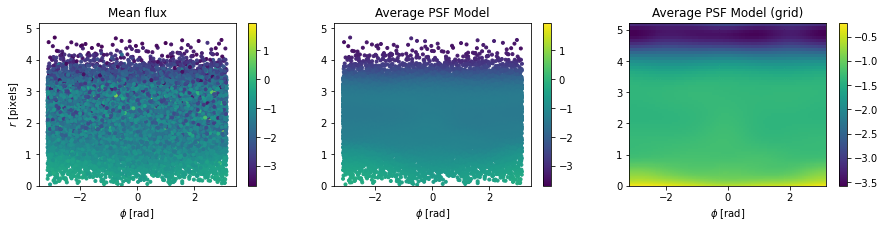

In [224]:
mean_model = build_psf_model(plot=True)

In [220]:
mean_model.sum(axis=1)

matrix([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      